In [1]:
#===============================
# example train with CST-Dataset
#===============================


#------------------------------------------------------------------
# This example use a tiny dataset called CST-Dataset
#
# CST-Dataset, Circle-Square-Triangle Dataset, is a simple tiny 
# object detection and segmentation dataset, has 1000 images, 
# contains only circles, squares and triangles in different scales,
# and the file size is just 25MB.
#
# Download link: https://github.com/GeeshangXu/cst-dataset
#
# download the dataset, set dataset path in below.
#---------------------------------------------------------------------

CST_ROOT_PATH = "/tmp/cst-dataset/"
DATA_FRACTION = 1  # fraction of data to train, val, test, 1 for using all data.

In [ ]:
#============================
# import some packages
#============================

import sys
import os
import pandas as pd
import numpy as np
from torchvision.transforms import ToPILImage
tensor2pil = ToPILImage()
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # uncomment when debug

# add mask-rcnn-pytorch root directory to PATH
sys.path.append("/home/geeshang/project/mask-rcnn-pytorch/")
from maskrcnn import MaskRCNN

In [3]:
#============================
# setup some constant values
#============================

BATCH_SIZE = 1
IMG_HEIGHT, IMG_WIDTH = 512, 512
NUM_CLASSES = 4
NUM_WORKERS = 4
GPU_NUM = 0
TRAIN_RPN_ONLY = False
MODEL_SVAE_PATH = "./"
# when use augmentation, bbox calculated on the fly, set extra space around
# tight bbox, in pixel.
BBOX_EXTRA_SPACE = 5

In [4]:
#===================================
# define cst-dataset for dataloader
#===================================

from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import random
import PIL

class CSTDataset(Dataset):
    
    def __init__(self, stage, transform=None):
        assert stage in ['train', 'val', 'test']
        self.stage = stage
        self.df_anno = pd.read_csv(os.path.join(CST_ROOT_PATH,
                                                "annotation",
                                                "anno-{}.csv".format(stage)))
        self.class_to_id = {name : idx + 1 for idx, name 
                            in enumerate(list(set(self.df_anno['class'])))}
        self.id_to_class = {idx + 1 : name for idx, name 
                            in enumerate(list(set(self.df_anno['class'])))}
        self.data_path = os.path.join(CST_ROOT_PATH, stage)
        self.image_ids = list(set(self.df_anno['image_id']))
        self.image_ids = random.sample(self.image_ids, 
                                       int(DATA_FRACTION * len(self.image_ids)))
        self.transform = transform
    
    def get_anno(self, seed, df):
        classes = [self.class_to_id[name] for name in df['class']]
        bboxes = []
        masks = []
        mask_paths = [os.path.join(self.data_path, path) for path in df['mask_path']]
        
        for path in mask_paths:
            m = PIL.Image.open(path)
            if self.transform is not None:
                random.seed(seed)
                m = self.transform(m, is_image=False)
                # when use transform, bbox should calculate on the fly.
                bbox = np.array(tensor2pil(m).getbbox())
                # make little bit space around mask
                bbox += np.array([-BBOX_EXTRA_SPACE, -BBOX_EXTRA_SPACE,
                                  BBOX_EXTRA_SPACE, BBOX_EXTRA_SPACE])
                bboxes.append(bbox)
            else:
                for b in df['bbox']:
                    bbox = [int(i) for i in b.split()]
                    bboxes.append(bbox)
            masks.append(m)
            
        return classes, bboxes, masks
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        df = self.df_anno[self.df_anno['image_id'] == image_id]
        image_path = os.path.join(self.data_path, image_id, "{}.jpg".format(image_id))
        image = PIL.Image.open(image_path)
        height, width = image.height, image.width
        
        # trick to transform image and mask synchronously by fixing seed.
        seed = random.randint(0, 88888888)
        if self.transform is not None:
            random.seed(seed)
            image = self.transform(image)
            
        if self.stage in ['train', 'val']:
            classes, bboxes, masks = self.get_anno(seed, df)
            gt_cls = torch.LongTensor(classes)
            gt_bbox = torch.cat([torch.FloatTensor(b).unsqueeze(0) for b in bboxes])
            gt_mask = torch.cat([m for m in masks])
            
            return image_id, image, gt_cls, gt_bbox, gt_mask
        else:
            
            return image_id, image, height, width
    
    def __len__(self):
        return len(self.image_ids)

In [5]:
#==================================
# transform and augmentation
#==================================

from torchvision.transforms import (Compose, Resize, ToTensor, Grayscale,
                                    RandomHorizontalFlip, RandomVerticalFlip)

train_image_composed = Compose([Grayscale(3),
                    RandomHorizontalFlip(),
                    RandomVerticalFlip(),
                    ToTensor()])

train_mask_composed = Compose([Grayscale(1),
                    RandomHorizontalFlip(),
                    RandomVerticalFlip(),
                    ToTensor()])

def train_transform(data, is_image=True):
    if is_image:
        return train_image_composed(data)
    else:
        return train_mask_composed(data)

def val_transform(data, is_image=True):
    return train_transform(data, is_image)

def test_transform(image):
    composed = Compose([Grayscale(3),
                    ToTensor()])
    return composed(image)

In [6]:
#=================
# init dataloader
#=================

train_dataset = CSTDataset(stage='train', transform=train_transform)
val_dataset = CSTDataset(stage='val', transform=val_transform)
test_dataset = CSTDataset(stage='test', transform=test_transform)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, num_workers=NUM_WORKERS)

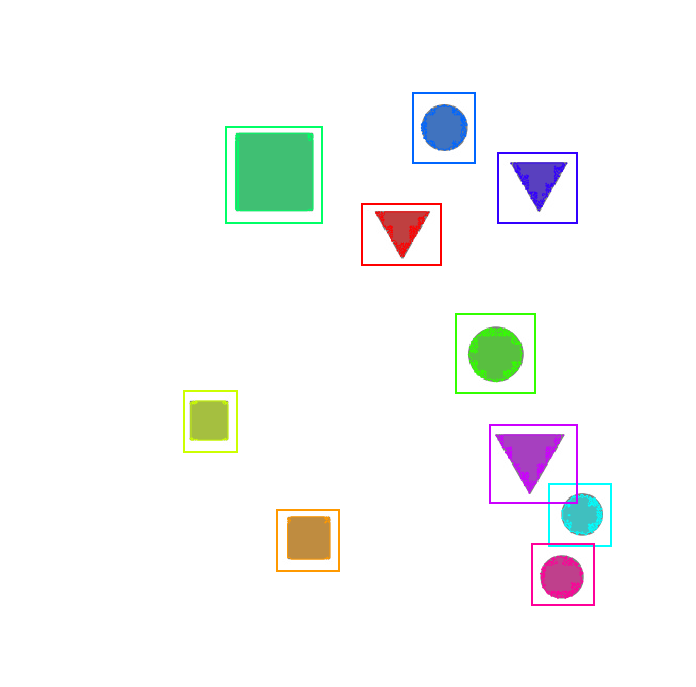

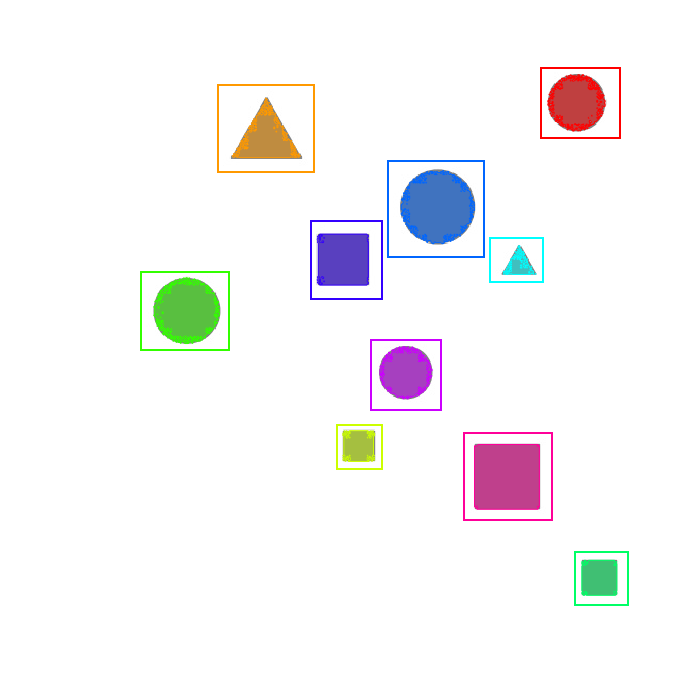

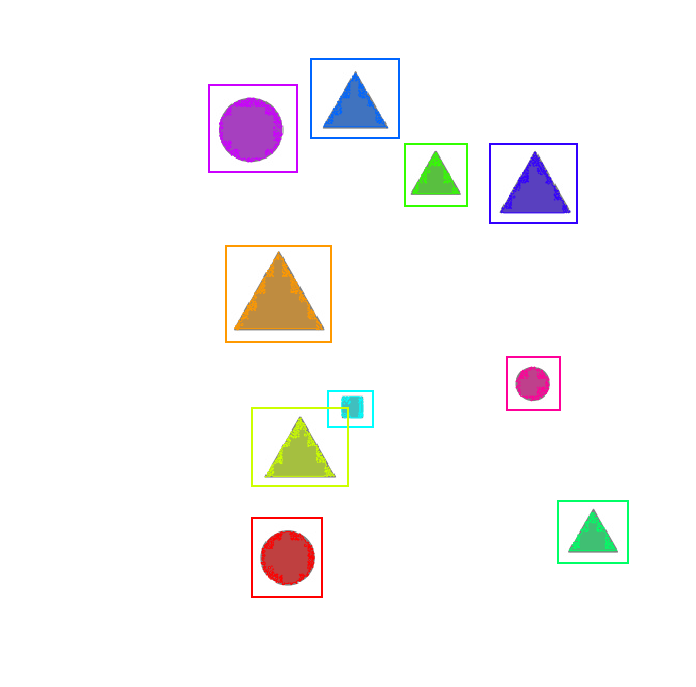

In [7]:
#==================
# check dataloader
#==================

from tools.visualize import draw_boxes, display_instances
import matplotlib.pyplot as plt
%matplotlib inline

check_count = 3
data_path = os.path.join(CST_ROOT_PATH, "train")
df_anno = pd.read_csv(os.path.join(CST_ROOT_PATH, 'annotation', 'anno-train.csv'))

for image_id, image, gt_cls, gt_bbox, gt_mask in train_dataloader:
    for i in range(train_dataloader.batch_size):
        df = df_anno[df_anno['image_id'] == image_id[i]]
        image = tensor2pil(image[i])
        gt_mask = gt_mask.squeeze(2)
        draw_boxes(np.array(image), refined_boxes=gt_bbox[i].numpy(),
                   masks=gt_mask[i].numpy())

    check_count -= 1
    if check_count == 0:
        break

In [ ]:
#==================================
# define train, val, test function
#==================================

from torch.autograd import Variable
from tqdm import tqdm_notebook
import time

def train_epoch(model, optimizer, epoch, loader):
    model.train()
    start_time = time.time()
    train_loss = 0
    
    for image_id, image, gt_cls, gt_bbox, gt_mask in tqdm_notebook(loader):
        image = image.cuda()
        gt_cls = gt_cls.cuda()
        gt_bbox = gt_bbox.cuda()
        gt_mask = gt_mask.cuda()
        
        optimizer.zero_grad()
        result, loss = model(image, gt_cls, gt_bbox, gt_mask)
        train_loss += loss.data
        loss.backward()
        optimizer.step() 
        
    output_str = "Train epoch: {} \t Train loss: {} \t Time elapse: {}s".format(
        epoch, round(train_loss[0] / len(loader), 4), int(time.time() - start_time))
    print(output_str)
    
def val_epoch(model, epoch, loader):
    model.eval()
    results = []
    img_ids = []
    val_loss = 0
    
    for image_id, image, gt_cls, gt_bbox, gt_mask in tqdm_notebook(loader):
        image = image.cuda()
        gt_cls = gt_cls.cuda()
        gt_bbox = gt_bbox.cuda()
        gt_mask = gt_mask.cuda()
    
        result, loss = model(image, gt_cls, gt_bbox, gt_mask)
        
        assert BATCH_SIZE == 1
        results.extend(result)
        img_ids.extend(image_id)
        val_loss += loss.data
        
    output_str = "Val loss: {}".format(round(val_loss[0] / len(loader), 4))
    print(output_str)

def train(model, optimizer, epochs):
    for epoch in range(1, epochs + 1): 
        train_epoch(model, optimizer, epoch, train_dataloader)
        val_epoch(model, epoch, val_dataloader)

def test(model, loader):
    model.eval()
    img_ids = []
    masks = []
    classes = []
    shapes = []
    props = []
    bboxes = []
    
    for image_id, image, height, width in tqdm_notebook(loader):
        image = image.cuda()
        result, loss = model(image)
        height, width = int(height), int(width)
        
        assert BATCH_SIZE == 1
        for obj in result[0]:
            img_ids.append(image_id[0])
            shapes.append((height, width))
            props.append(obj['proposal'].numpy())
            if not TRAIN_RPN_ONLY:
                masks.append(obj['mask_pred'].numpy())
                bboxes.append(obj['bbox_pred'].numpy())
                classes.append(int(obj['cls_pred']))
    
    df = pd.DataFrame()
    df['image_id'] = img_ids
    df['shape'] = shapes
    df['proposal'] = props
    
    if not TRAIN_RPN_ONLY:
        df['class'] = classes
        df['mask'] = masks
        df['bbox'] = bboxes
    
    return df

In [ ]:
#==========
# training
#==========

model_path = os.path.join(MODEL_SVAE_PATH, "./cst-maskrcnn.state")

with torch.cuda.device(GPU_NUM):
    model = MaskRCNN(num_classes=NUM_CLASSES, pretrained="imagenet").cuda()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=0.0001, weight_decay=0.0001)
    train(model, optimizer, 3)
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=0.00001, weight_decay=0.0001)
    train(model, optimizer, 2)
    torch.save(model.state_dict(), model_path)

In [ ]:
#=========
# testing
#=========

with torch.cuda.device(GPU_NUM):
    model = MaskRCNN(num_classes=NUM_CLASSES, pretrained="imagenet").cuda()
    model.load_state_dict(torch.load(model_path, 
                                     map_location=lambda storage, loc: storage))
    df_test = test(model, test_dataloader)

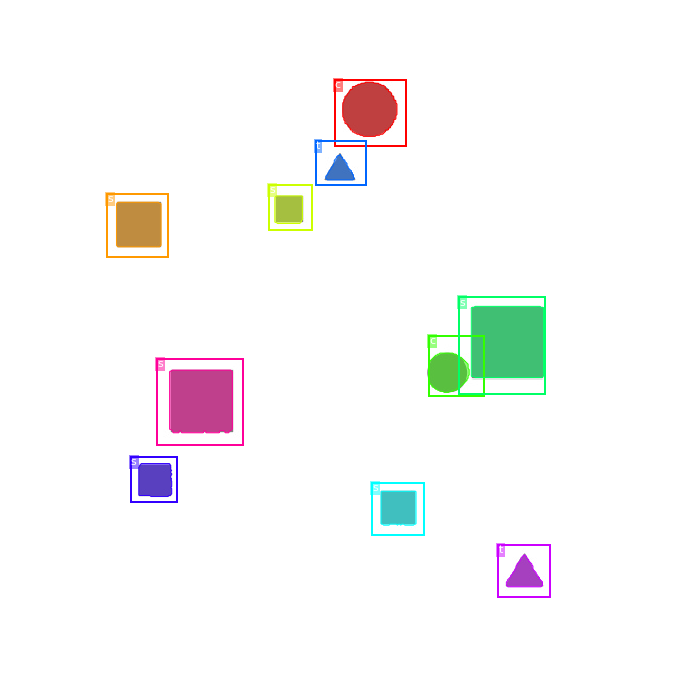

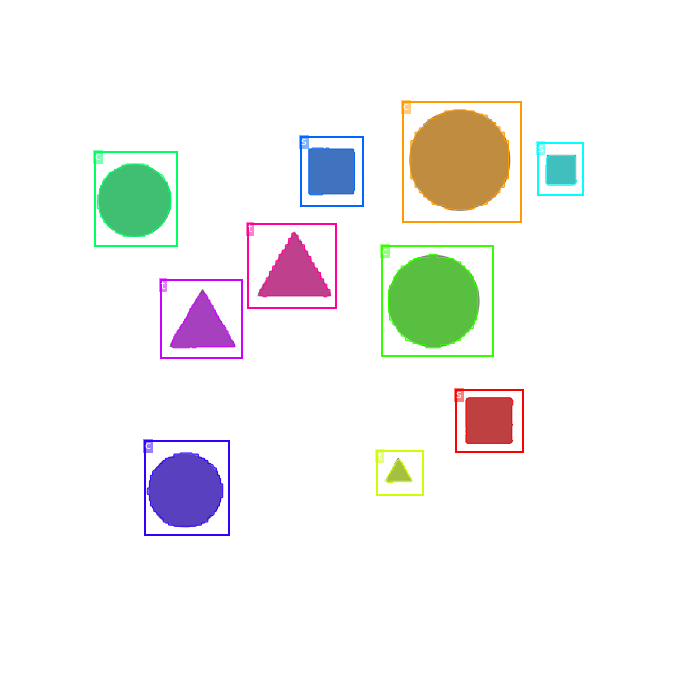

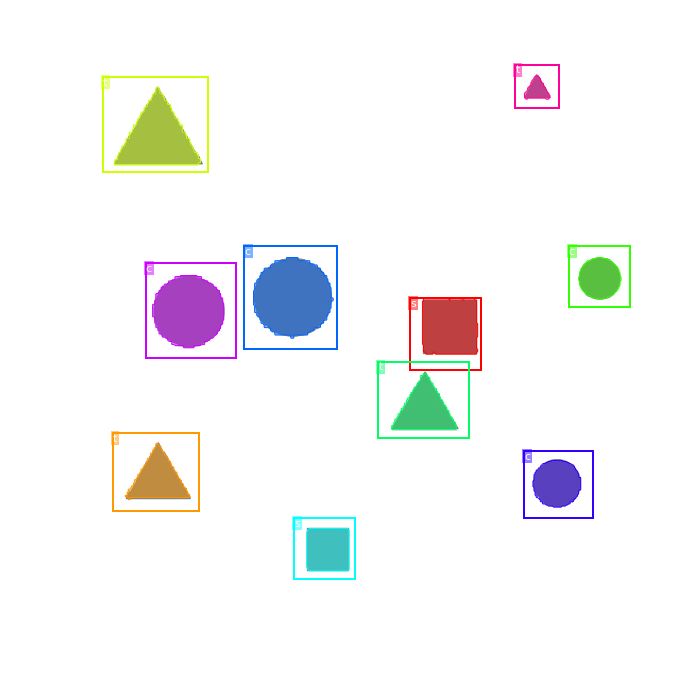

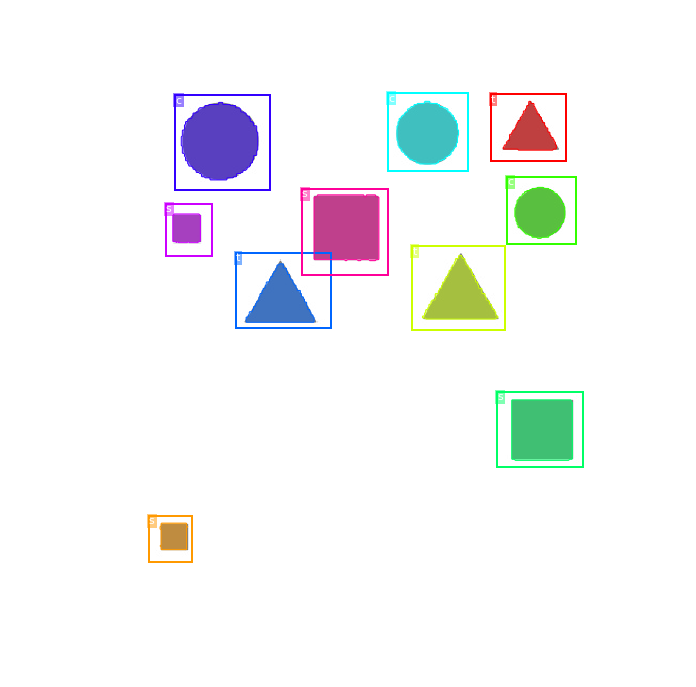

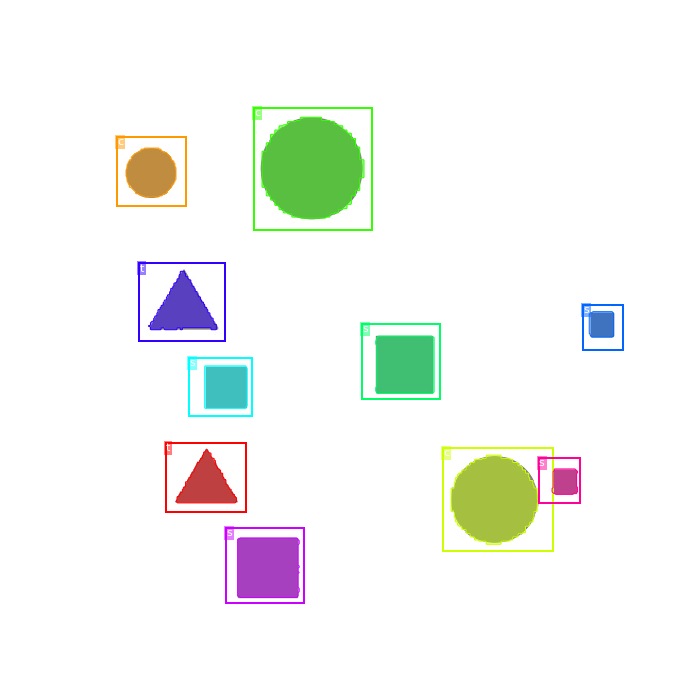

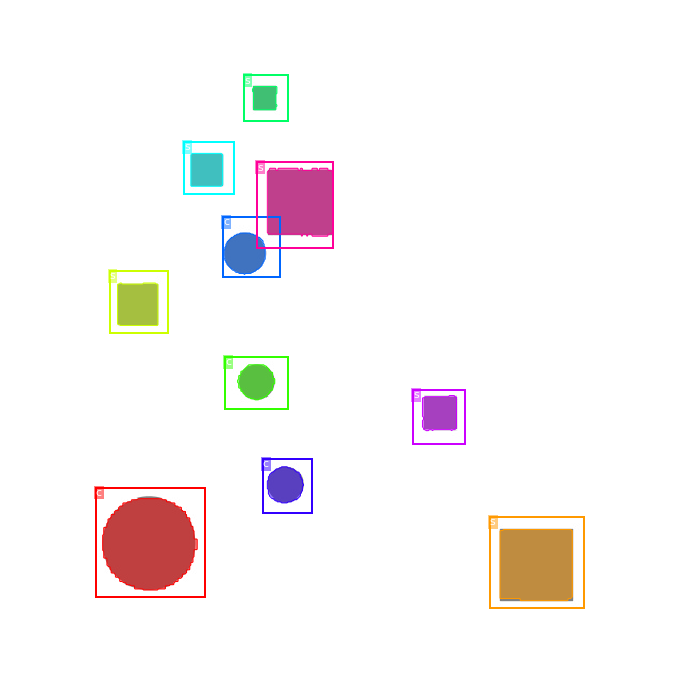

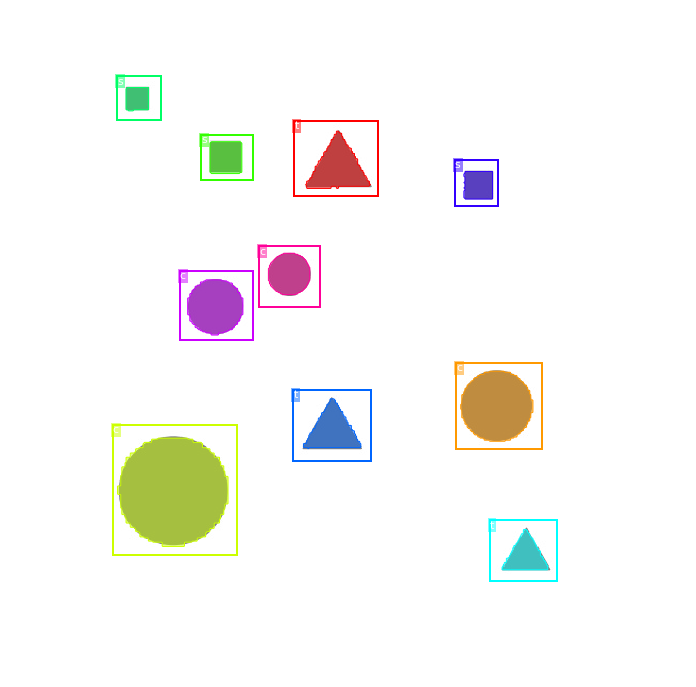

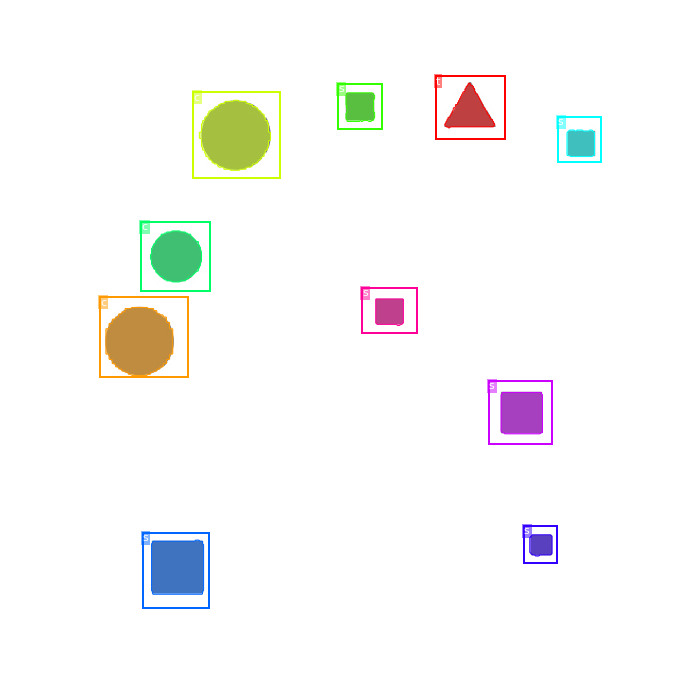

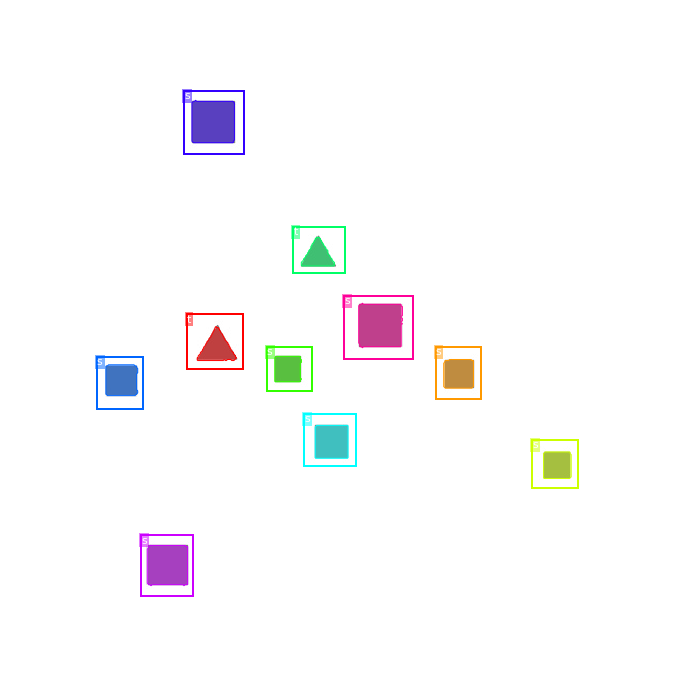

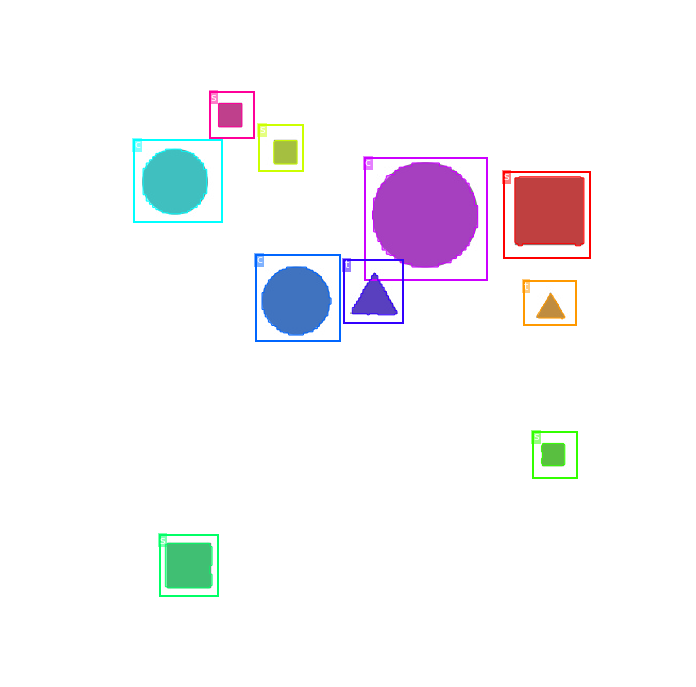

In [10]:
#======================
# check predict result
#======================

from tools.visualize import draw_boxes, display_instances
import numpy as np
%matplotlib inline

check_ids = random.sample(set(df_test['image_id']), 10)

for img_id in check_ids:
    img_path = os.path.join(CST_ROOT_PATH, "test", img_id, img_id + ".jpg")
    image = PIL.Image.open(img_path)
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    props = list(df_test[df_test['image_id'] == img_id]['proposal'])
    if TRAIN_RPN_ONLY:
        draw_boxes(np.array(image), boxes=np.array(props)) 
    else:
        df = df_test[df_test['image_id'] == img_id]
        masks = list(df['mask'])
        bboxes = list(df['bbox'])
        classes = list(test_dataset.id_to_class[i] for i in df['class'])
        draw_boxes(np.array(image), refined_boxes=np.array(bboxes), 
                   captions=classes, masks=np.array(masks))